<a href="https://colab.research.google.com/github/karanjogi/Kaggle/blob/master/Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

In [65]:
df = pd.read_csv("/content/train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


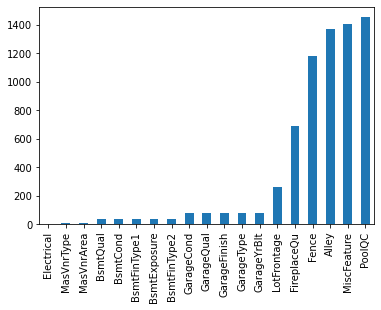

In [66]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values()
missing.plot.bar()

In [0]:
df.drop(missing[missing > 200],
        inplace=True)

In [0]:
numeric = [col for col in df.columns if df.dtypes[col] != 'object']
numeric.remove('SalePrice')
numeric.remove('Id')
categorical = [col for col in df.columns if df.dtypes[col] == 'object']


In [0]:
target = df['SalePrice']

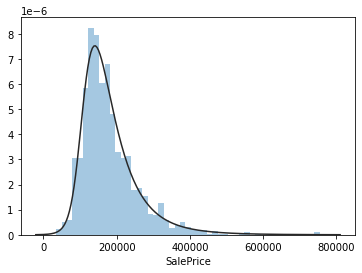

In [70]:
sns.distplot(target,
             kde=False,
             fit=st.johnsonsu);

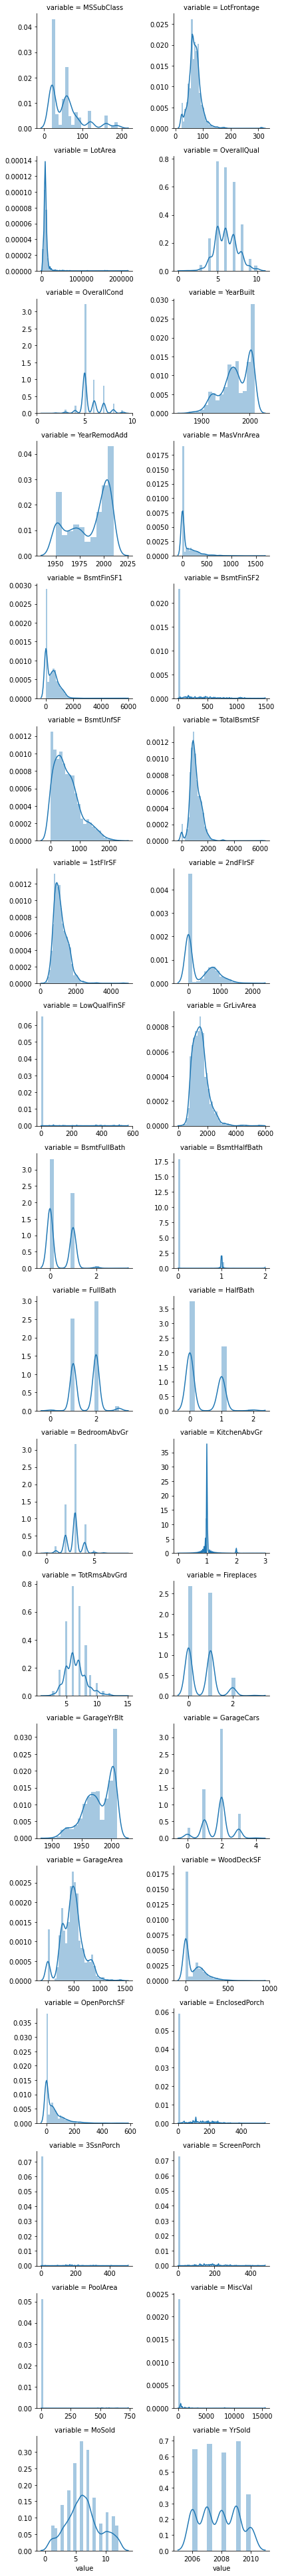

In [71]:
f = pd.melt(df,
            value_vars=numeric)
grid = sns.FacetGrid(f,
                     col='variable',
                     col_wrap=2,
                     sharex=False,
                     sharey=False)
grid = grid.map(sns.distplot,
                "value");


In [0]:
for category in categorical:
  df[category] = df[category].astype('category')
  if df[category].isnull().any():
    df[category] = df[category].cat.add_categories(['missing'])
    df[category].fillna('missing',
                        inplace=True)

In [0]:
def boxplot(x, y, **kwargs):
  sns.boxplot(x=x,
              y=y);
  x=plt.xticks(rotation=90)

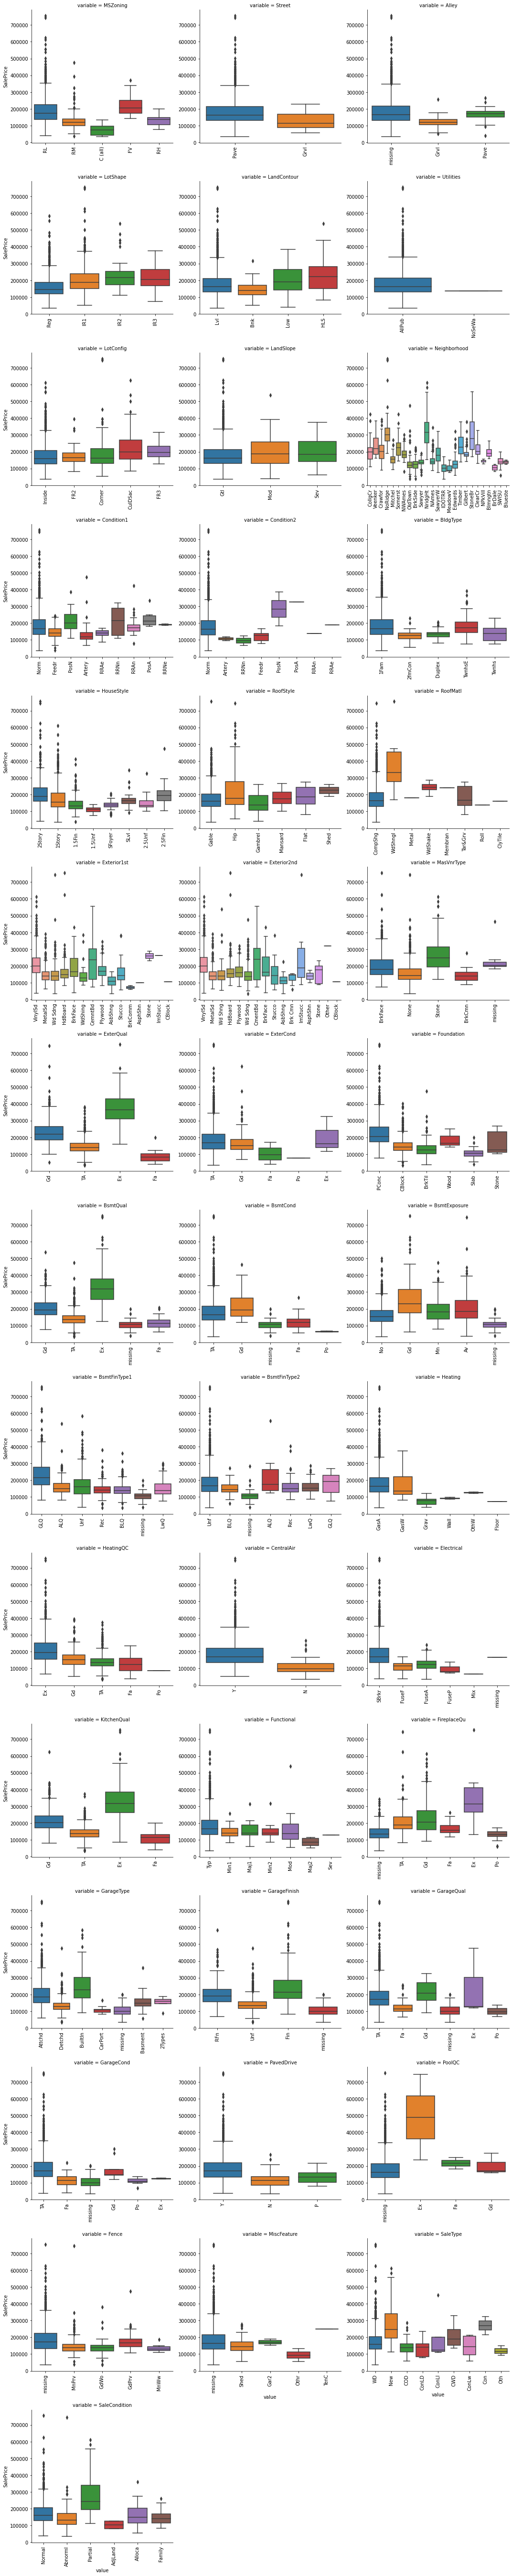

In [78]:
f = pd.melt(df,
            id_vars='SalePrice',
            value_vars=categorical)

grid = sns.FacetGrid(f,
                     col="variable",
                     col_wrap=3,
                     sharex=False,
                     sharey=False,
                     height=5)

grid = grid.map(boxplot,
                "value",
                "SalePrice")

In [0]:
corr_mat_nona = df.dropna().corr()

In [0]:
corr_mat_nona.tail(1)

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
SalePrice,-0.030473,-0.079599,0.254757,0.783546,-0.108627,0.504297,0.501435,0.465811,0.359677,-0.031226,0.191689,0.602042,0.604714,0.311354,-0.009992,0.711706,0.209695,-0.030175,0.569313,0.258175,0.169266,-0.111408,0.551821,0.445434,0.48173,0.640154,0.607535,0.305983,0.322786,-0.127385,0.042159,0.096624,0.091881,-0.01699,0.04131,-0.020451,1.0


In [0]:
#using sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [0]:
dropped_df = df.dropna()

In [0]:
numeric_dropped = dropped_df.select_dtypes(exclude='object')

In [0]:
numeric_dropped.drop("Id", axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
numeric_mat = numeric_dropped.to_numpy()
numeric_mat.shape

(1338, 36)

In [0]:
fs = SelectKBest(score_func=f_regression, k = 17)
X = fs.fit_transform(numeric_mat[:, : -1], numeric_mat[:, -1])
X.shape

(1338, 17)

In [0]:
#Standardize Inputs
from sklearn.preprocessing import StandardScaler
X_stand = X.copy()
for i in range(len(X_stand[0])):
  scale = StandardScaler().fit(X[[i]])

  X_stand = scale.transform(X_stand)

In [0]:
#Normalized Inputs
from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler().fit(X)
X_norm = norm.transform(X)

In [0]:
y = numeric_mat[:, -1]

In [0]:
ones = np.ones(X.shape)[:, 0]

In [0]:
X = np.append(ones[:, None], X[:], axis=1)
X_stand = np.append(ones[:, None], X_stand[:], axis=1)
X_norm = np.append(ones[:, None], X_norm[:], axis=1)

In [0]:
def fit(X, Y):
  l2 = 1000.0
  w = np.linalg.solve(l2*np.eye(len(X[0])) + X.T.dot(X), X.T.dot(Y))
  Yhat = X.dot(w)
  return Yhat

def calculate_r2(y, Yhat):
  d1 = y - Yhat
  d2 = y - y.mean()
  r2 = 1 - d1.dot(d1) / d2.dot(d2)
  return r2

  #Using Gradient Descent
def fit_gd(X, Y, lr=0.001, epochs=100):
  N, D = len(X), len(X[0])
  costs = []
  w_gd = np.random.randn(D) / np.sqrt(D)
  for t in range(epochs):
    Yhat = X.dot(w_gd)
    delta = Yhat - Y
    w_gd = w_gd - lr*X.T.dot(delta)
    mse = delta.dot(delta) / N
    costs.append(mse)

  plt.plot(costs)
  plt.show()
  return Yhat, costs[-1]

In [0]:
Yhat = fit(X, y)
r2 = calculate_r2(y, Yhat)

In [0]:
Yhat_stand = fit(X_stand, y)
r2_stand = calculate_r2(y, Yhat_stand)

In [0]:
Yhat_norm = fit(X_norm, y)
r2_norm = calculate_r2(y, Yhat_norm)

In [0]:
print("R2 Error for non standardized input:", r2)
print("R2 Error for standardized input:", r2_stand)
print("R2 Error for normalized input:", r2_norm)

R2 Error for non standardized input: 0.7533277647138807
R2 Error for standardized input: 0.7480608055947479
R2 Error for normalized input: 0.37953103782433417


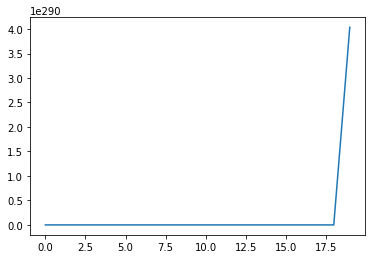

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in subtract


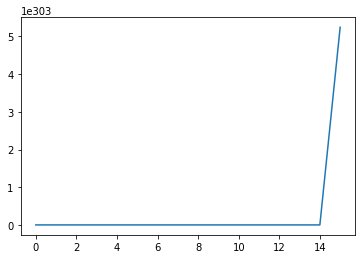

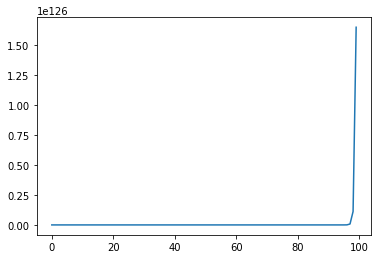

In [0]:
Yhat_gd, r2_gd = fit_gd(X, y)
Yhat_stand_gd, r2_stand_gd = fit_gd(X_stand, y)
Yhat_norm_gd, r2_norm_gd = fit_gd(X_norm, y)

In [0]:
print("GD R2 Error for non standardized input:", r2_gd)
print("GD R2 Error for standardized input:", r2_stand_gd)
print("GD R2 Error for normalized input:", r2_norm_gd)

GD R2 Error for non standardized input: nan
GD R2 Error for standardized input: nan
GD R2 Error for normalized input: 1.648379751453081e+126
